# Analyzing Police Activity

## Alan T. / May 2022

In this project, I´ll be analyzing police traffic stops in the state of Rhode Island and answering questions and testing hypothesis along the way. Then, I will merge weather data to look for correlations between traffic stop behaviours and weather. 

This project is mostly based on DataCamps "Analyzing Police Activity" project from the Data Scientist Learning Track, however, I added quite a few more steps, analysis and visualizations vs. the project's instructions. 

The raw police stops data is publicly available from the [Stanford´s Project Website](https://openpolicing.stanford.edu/data/) and the raw weather data is publicly available from the [NOAA Website](https://www.ncdc.noaa.gov/cdo-web/). However, the cleaned versions of the data, used for this project, are available in my Github repository. 

Let´s dive in.

### Importing the necessary libraries and modules

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

### Importing and cleaning the data

In [2]:
# Import csv file
ri = pd.read_csv("police_data.txt")

In [3]:
# First inspection of the dataset
ri.head(10)

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3
5,RI,2005-03-14,10:00,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
6,RI,2005-03-29,21:55,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
7,RI,2005-04-04,21:25,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K1
8,RI,2005-07-14,11:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
9,RI,2005-07-14,19:55,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4


In [4]:
# Explore the values per column and the datatypes
print(ri.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91741 entries, 0 to 91740
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   state               91741 non-null  object 
 1   stop_date           91741 non-null  object 
 2   stop_time           91741 non-null  object 
 3   county_name         0 non-null      float64
 4   driver_gender       86536 non-null  object 
 5   driver_race         86539 non-null  object 
 6   violation_raw       86539 non-null  object 
 7   violation           86539 non-null  object 
 8   search_conducted    91741 non-null  bool   
 9   search_type         3307 non-null   object 
 10  stop_outcome        86539 non-null  object 
 11  is_arrested         86539 non-null  object 
 12  stop_duration       86539 non-null  object 
 13  drugs_related_stop  91741 non-null  bool   
 14  district            91741 non-null  object 
dtypes: bool(2), float64(1), object(12)
memory usage: 9.3+

In [5]:
# Inspect NANs per column
ri.isnull().sum()

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

The county_name column contains 91,741 NaNs, the same number as the total data length meaning that the column is only made up of NaNs. I can drop the county_name and the state (since all data is from RI) columns:

In [6]:
# Dropping county_name and "state" columns
ri.drop(["county_name", "state"], axis = "columns", inplace = True)
ri.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

I pass to the df.drop method the column name, the axis parameter set to columns to indicate that i will be dropping a column, and the inplace parameter set to true to drop the column from the original dataset instead of creating a copy of it. 

One of the critical columns for this analysis is the driver_gender column. Since there are 5,205 NaNs in the column, which represents around 5% of the total data, I can drop the rows that don´t contain driver_gender information. 

To do so, I use the dropna method that will drop all rows that contain NaNs. I can pass the subset parameter to select only the columns to consider while dropping NaNs. Since I'm only interested in driver_gender, I pass in to to subset to drop only rows where driver_gender is NaN.

In [7]:
# Calculate % of NaNs for driver_gender
driver_gender_pct = 5205 / 91741
print(driver_gender_pct)

0.056735810597224795


In [8]:
# Drop driver_gender NaNs
ri.dropna(subset = ["driver_gender"], inplace = True)

In [9]:
ri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86536 entries, 0 to 91740
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   stop_date           86536 non-null  object
 1   stop_time           86536 non-null  object
 2   driver_gender       86536 non-null  object
 3   driver_race         86536 non-null  object
 4   violation_raw       86536 non-null  object
 5   violation           86536 non-null  object
 6   search_conducted    86536 non-null  bool  
 7   search_type         3307 non-null   object
 8   stop_outcome        86536 non-null  object
 9   is_arrested         86536 non-null  object
 10  stop_duration       86536 non-null  object
 11  drugs_related_stop  86536 non-null  bool  
 12  district            86536 non-null  object
dtypes: bool(2), object(11)
memory usage: 8.1+ MB


Part of the cleaning data task is to verify that the correct datatypes match the data. In this case, I can see that is_arrested is an object(str), while the values are True or False. I must convert the object type into boolean datatype. To convert datatypes, I can use pandas astype method to convert any data type into a different one. 

In [10]:
# Astype to convert data type
ri["is_arrested"] = ri.is_arrested.astype("bool")

# Confirm dtype as boolean
print(ri.is_arrested.dtype)

bool


The stop_date and stop_time columns are stored as str objects as well. In order to perform analysis by date, filtering data and plotting the data, I need to change these data types to datetime objects. 

For this, I will first combine stop_date and stop_time in a single column, separating them with a space with the str.cat method. Then, I will use the pandas to_datetime method to convert it to a date_time object. At last, I'll set the new column as a datetime index for ease of filtering and analyzing the data. 

In [11]:
# COncantenate and separate with a blank space date and time
date_time_str = ri.stop_date.str.cat(ri.stop_time, sep = " ")

# Create new column with concatenated data as datetime type
ri["stop_date_time"] = pd.to_datetime(date_time_str)

# Confirm conversion to datetime object
ri.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86536 entries, 0 to 91740
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   stop_date           86536 non-null  object        
 1   stop_time           86536 non-null  object        
 2   driver_gender       86536 non-null  object        
 3   driver_race         86536 non-null  object        
 4   violation_raw       86536 non-null  object        
 5   violation           86536 non-null  object        
 6   search_conducted    86536 non-null  bool          
 7   search_type         3307 non-null   object        
 8   stop_outcome        86536 non-null  object        
 9   is_arrested         86536 non-null  bool          
 10  stop_duration       86536 non-null  object        
 11  drugs_related_stop  86536 non-null  bool          
 12  district            86536 non-null  object        
 13  stop_date_time      86536 non-null  datetime64

In [12]:
# Set stop_date_time as index
ri.set_index("stop_date_time", inplace = True)

# Inspect the index
ri.index

DatetimeIndex(['2005-01-04 12:55:00', '2005-01-23 23:15:00',
               '2005-02-17 04:15:00', '2005-02-20 17:15:00',
               '2005-02-24 01:20:00', '2005-03-14 10:00:00',
               '2005-03-29 21:55:00', '2005-04-04 21:25:00',
               '2005-07-14 11:20:00', '2005-07-14 19:55:00',
               ...
               '2015-12-31 13:23:00', '2015-12-31 18:59:00',
               '2015-12-31 19:13:00', '2015-12-31 20:20:00',
               '2015-12-31 20:50:00', '2015-12-31 21:21:00',
               '2015-12-31 21:59:00', '2015-12-31 22:04:00',
               '2015-12-31 22:09:00', '2015-12-31 22:47:00'],
              dtype='datetime64[ns]', name='stop_date_time', length=86536, freq=None)

### Data exploration

In this part of the analysis, I will explore the relationships of different attributes of the data. The intention of this part is not to draw any conclusions about causation since I would need additional data and expertise to do so, but to bocus on the relationship between the varaibles. 

In [13]:
# Explore the stop_outcomes
ri.stop_outcome.value_counts()

Citation            77091
Warning              5136
Arrest Driver        2735
No Action             624
N/D                   607
Arrest Passenger      343
Name: stop_outcome, dtype: int64

In [14]:
# Set normalize to True to count the values as the proportion of the total
ri.stop_outcome.value_counts(normalize = True)

Citation            0.890855
Warning             0.059351
Arrest Driver       0.031605
No Action           0.007211
N/D                 0.007014
Arrest Passenger    0.003964
Name: stop_outcome, dtype: float64

In [15]:
# Explore the traffic stops by race
ri.driver_race.value_counts()

White       61870
Black       12285
Hispanic     9727
Asian        2389
Other         265
Name: driver_race, dtype: int64

In [16]:
# Comparing outcomes between two races
white = ri[ri.driver_race == "White"]

print(white.stop_outcome.value_counts(normalize = True))

Citation            0.902263
Warning             0.057508
Arrest Driver       0.024018
No Action           0.007031
N/D                 0.006433
Arrest Passenger    0.002748
Name: stop_outcome, dtype: float64


In [17]:
hispanic = ri[ri.driver_race == "Hispanic"]
print(hispanic.stop_outcome.value_counts(normalize = True))

Citation            0.852061
Warning             0.067441
Arrest Driver       0.055310
N/D                 0.009458
No Action           0.008841
Arrest Passenger    0.006888
Name: stop_outcome, dtype: float64


In this fist comparisson, it is clear that white drivers get a citation (ticket) around 90% of the time, while hispanic drivers get a citation 85% of the times. In the other hand, white drivers get arrested around 2% of the time while hispanic drivers end up arrested almost 6% of the times. This, however, doesn´t indicate that hipsanic drivers get more arrests than white drivers since the total number of drivers / stops isn't considered

I will investigate to see if different types of violations are committed by males and females. 

In [18]:
# Create a DataFrame for each gender
female = ri[ri["driver_gender"] == "F"]
male = ri[ri["driver_gender"] == "M"]

In [19]:
# Investigate the female violations
print(female.violation.value_counts(normalize = True))

Speeding               0.658114
Moving violation       0.138218
Equipment              0.105199
Registration/plates    0.044418
Other                  0.029738
Seat belt              0.024312
Name: violation, dtype: float64


In [20]:
# Investigate the male violatons
print(male.violation.value_counts(normalize = True))

Speeding               0.522243
Moving violation       0.206144
Equipment              0.134158
Other                  0.058985
Registration/plates    0.042175
Seat belt              0.036296
Name: violation, dtype: float64


In this comparisson, I can see that woman are stopped for speeding almost 66% of the time! Males, on the other side, incur more often to the other violations category more often. 

In order to actually analyze if gender affects getting a ticket, I will analyze both genders for a speeding violation. For this, I´ll create one DataFrame for each gender where the violation is speeding. 

In [21]:
# Create 1 dataset for each gender and where the violation is speeding. 
speeding_female = ri[(ri.driver_gender == "F") & (ri.violation == "Speeding")]
speeding_male = ri[(ri.driver_gender == "M") & (ri.violation == "Speeding")]

In [22]:
# Analyze the outcomes
print(speeding_female.stop_outcome.value_counts(normalize = True))

Citation            0.952192
Warning             0.040074
Arrest Driver       0.005752
N/D                 0.000959
Arrest Passenger    0.000639
No Action           0.000383
Name: stop_outcome, dtype: float64


In [23]:
print(speeding_male.stop_outcome.value_counts(normalize = True))

Citation            0.944595
Warning             0.036184
Arrest Driver       0.015895
Arrest Passenger    0.001281
No Action           0.001068
N/D                 0.000976
Name: stop_outcome, dtype: float64


Since this analysis does consider the total amount od drivers and stops, I can conclude that the driver gender doesn´t have an impact on getting a speeding ticket or not, since both genders have around 95% chance of getting a ticket for speeding. 

Now I will investigate the relationship between driver gender and vehicle searches, using the search_conducted column. As a reminder, mathematical opeartions can be performed on boolean values (False = 0, True = 1)

In [24]:
# First, I will calculate the vehicle search rate of the overall data
print(ri.search_conducted.value_counts(normalize = True))

False    0.961785
True     0.038215
Name: search_conducted, dtype: float64


Interesting, almost 4% of traffic stops included a vehicle search. 
I could also have calculated the search_conducted mean by taking the mean of the series:

ri.search_conducted.mean() = 0.038

In [25]:
# Calculate the mean of search_conducted by driver_gender
print(ri.groupby("driver_gender").search_conducted.mean())

driver_gender
F    0.019181
M    0.045426
Name: search_conducted, dtype: float64


This result reveals that male drivers have their vehicle searched twice as much times as female drivers. It is possible that the difference is derived from a second factor. 

I will explore the rate of vehicle searches grouped by gender and violation incurred. 

In [26]:
print(ri.groupby(["violation", "driver_gender"]).search_conducted.mean())

violation            driver_gender
Equipment            F                0.039984
                     M                0.071496
Moving violation     F                0.039257
                     M                0.061524
Other                F                0.041018
                     M                0.046191
Registration/plates  F                0.054924
                     M                0.108802
Seat belt            F                0.017301
                     M                0.035119
Speeding             F                0.008309
                     M                0.027885
Name: search_conducted, dtype: float64


This result shows that for all violations, men have their cars searched twice as much than female drivers.

I will conduct an investigation on the vehicle search types, specifically, the Inventory search where police officers took an inventory of the vehicle. 

In [27]:
ri.search_type.value_counts()

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Incident to Arrest,Inventory,Probable Cause                   35
Probable Cause,Protective Frisk                               35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

I explore the different types of searaches and find that there 5 vehicle search types (incident to arrest, probable cause, inventory, reasonable suspicion, and protective frisk). Howver, other search types have ocrurred where more than one search type was conducted. For this cases, the multiple search types are separated by a comma.

219 where the times taht only invenotry was the vehicle search type, but I want to investigate further and calculate the total number of times that inventory was part of a search type, inlcuding inventory as one os multiple search types.

In [28]:
# Create new boolean column that equals to True if the search type contains "Inventory", using the string method
# str.contains and setting the na parameter to false to set NaNs as False. 
ri["inventory"] = ri.search_type.str.contains("Inventory", na = False)
ri.head()

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,inventory
stop_date_time,,,,,,,,,,,,,,
2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False
2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False
2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False
2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False
2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False


In [29]:
# Total inventory searches
print(ri.inventory.sum())

441


441 searches included Intentory as part of the vehicle search. What does that mean in terms of proportion? To find out, I have to first filter out the data to include only stops where a search was performed and then calculate the proportion of inventory searches out of it. 

In [30]:
searched = ri[ri.search_conducted == True]
searched.inventory.mean()

0.13335349259147264

13.3% of all vehicle searches included an inventory of the vehicle! How is this percentage distributed on each driver gender?

In [31]:
searched.groupby("driver_gender").inventory.mean()

driver_gender
F    0.175439
M    0.126622
Name: inventory, dtype: float64

Almost 18% of the inventory searches were for female drivers, and 13% for male drivers.

I will now analyzing the time trends for police activity. I´ll begin with the hourly arrest trend to explore the relationship of hour of the day vs. arrests made.

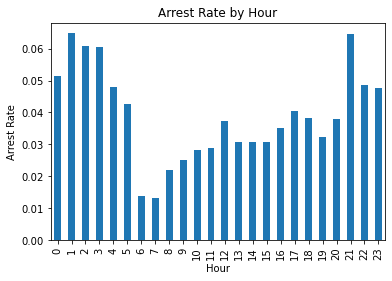

In [32]:
# Group by index and calculate mean
hourly_arrests = ri.groupby(ri.index.hour).is_arrested.mean()

#Visualize results
hourly_arrests.plot(kind = "bar")
plt.xlabel("Hour")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate by Hour")
plt.show()

The graph displays how the arrest rate increases with the time of the day. The lowst arrest rates occur between 6 and 8 am, and they gradually increase until night comes, where arrest rate increases significally from 9 pm to 5 am.

I will keep exploring for insights. Have drug related stops increased over time?
To find out, I will resample the data using the datetime index, meaning that I will group the data by other groups, being this case,  by year, and then calculating the arrest average rate per year. 

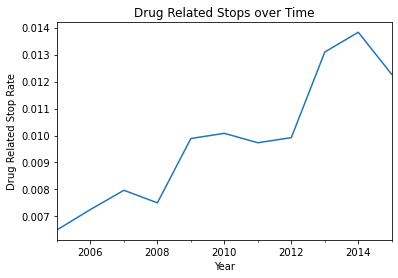

In [33]:
annual_drug_stop = ri.drugs_related_stop.resample("A").mean()
annual_drug_stop.plot()
plt.xlabel("Year")
plt.ylabel("Drug Related Stop Rate")
plt.title("Drug Related Stops over Time")
plt.show()

The drug related stops have increase significally over time. This leads me to thinking that searches increased at the same pace. To investigate this hypothesis, I´ll compare the trends of the search conducted stops. 

I will resample the search conducted stops into an annual basis and then I will merge the drug stops and the search stops into a single DataFrame using pandas concat method, passing both DF names to it and setting the axis argument to "columns" to concatenate along the columns index (side by side, matching datetime index).

In [34]:
annual_search_rate = ri.search_conducted.resample("A").mean()
annual = pd.concat([annual_drug_stop, annual_search_rate], axis = "columns")
annual.head()

,drugs_related_stop,search_conducted
stop_date_time,,
2005-12-31,0.006501,0.049167
2006-12-31,0.007258,0.041758
2007-12-31,0.007970,0.044056
2008-12-31,0.007505,0.040310
2009-12-31,0.009889,0.049861


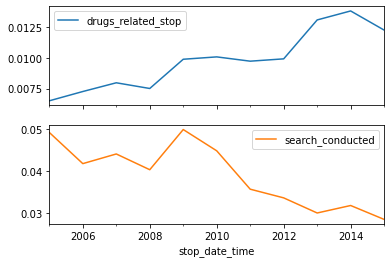

In [35]:
annual.plot(subplots = True)
plt.show()

As it turns out, the hypothesis is disapproved with this graph. Even though drug related stops have been on the rise, stops with search conducted have been declining almost at the same rate.

Now let´s investgate the number of drivers stopped and visualize them by race and gender. I will use seaborn's catplot (categorical plot), set the style to white grid to create a grid, set the catplot to a count plot, passing the desired order to visualize the categories, and separating the gender using colors:

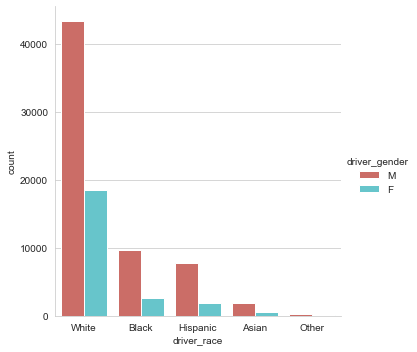

In [36]:
# Set whitegrid style
sns.set_style("whitegrid")

# Create the order list
order = ["White", "Black", "Hispanic", "Asian", "Other"]

# Create the seaborn count plot
sns.catplot(x = "driver_race", data = ri, kind = "count", hue = "driver_gender", palette = "hls", order = order)

This plot shows how men across all analyzed races are stopped twice as much as female drivers.

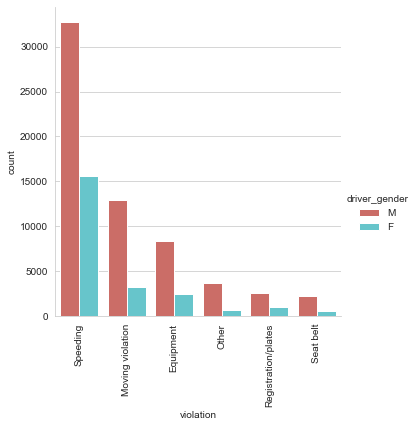

In [37]:
# Create violation order list
violation_order = ["Speeding", "Moving violation", "Equipment", "Other", "Registration/plates", "Seat belt"]

# Create count plot and rotate labels 90 degrees
g = sns.catplot(x = "violation", kind = "count", data = ri, hue = "driver_gender", palette = "hls", order = violation_order)
g.set_xticklabels(rotation = 90)

In this plot, we can see how male drivers commit twice as much violations when compared to women within this dataset. 

Let´s see the distribution of violations per district:

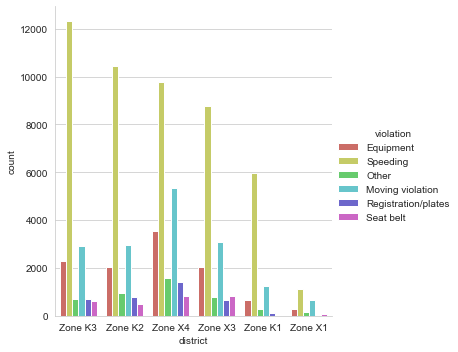

In [38]:
district_order = ["Zone K3", "Zone K2", "Zone X4", "Zone X3", "Zone K1", "Zone X1"]
sns.catplot(x = "district", kind = "count", data = ri, hue = "violation", palette = "hls", order = district_order) 

Another alternative to achieve this result is by creating a frequency table using panda's crosstab method:

In [39]:
# Create a frequency table of violations per district using pandas crosstab method
all_zones = pd.crosstab(ri.district, ri.violation)
print(all_zones)

violation  Equipment  Moving violation  Other  Registration/plates  Seat belt  \
district                                                                        
Zone K1          672              1254    290                  120          0   
Zone K2         2061              2962    942                  768        481   
Zone K3         2302              2898    705                  695        638   
Zone X1          296               671    143                   38         74   
Zone X3         2049              3086    769                  671        820   
Zone X4         3541              5353   1560                 1411        843   

violation  Speeding  
district             
Zone K1        5960  
Zone K2       10448  
Zone K3       12322  
Zone X1        1119  
Zone X3        8779  
Zone X4        9795  


In [40]:
# Select a slice of zones using loc
selected_zones = all_zones.loc["Zone K1": "Zone K3"]
print(selected_zones)

violation  Equipment  Moving violation  Other  Registration/plates  Seat belt  \
district                                                                        
Zone K1          672              1254    290                  120          0   
Zone K2         2061              2962    942                  768        481   
Zone K3         2302              2898    705                  695        638   

violation  Speeding  
district             
Zone K1        5960  
Zone K2       10448  
Zone K3       12322  


<AxesSubplot:xlabel='district'>

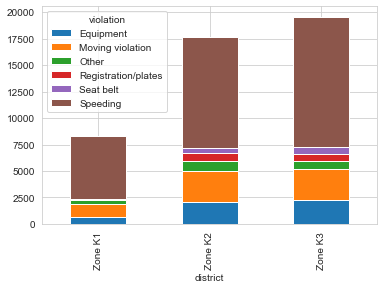

In [41]:
# Create a stacked bar plot of the selected zones
selected_zones.plot(kind = "bar", stacked = True)

Now lets investigate the durations of the stops. The stop_duration column contains the duration of each stop as a range of minutes (0-15 min, 16-30 min, 30+ min); I will map a category group to each of this values in order to perform analysis on them. Pandas has the mapping function that allows us to asign a value to a different value using dictionaries and keys. For example, to map 0-15 min to 8 (avg.) i would create the dictionary {"0-15 min": 8 } and assign this value in a different column. 

In [42]:
# Get all the unique values of the stop_duration columns
print(ri.stop_duration.unique())

['0-15 Min' '16-30 Min' '30+ Min']


In [43]:
# Create the mapping dictionary with keys as current values and values as the data to replace them
mapping_dict = {"0-15 Min":8, "16-30 Min":23, "30+ Min":45}

# Map the dictionary onto the variables to replace, in a new column
ri["stop_minutes"] = ri.stop_duration.map(mapping_dict)

#Verify
print(ri.stop_minutes.unique())

[ 8 23 45]


In [44]:
ri.head(10)

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,inventory,stop_minutes
stop_date_time,,,,,,,,,,,,,,,
2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8
2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8
2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8
2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False,23
2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False,8
2005-03-14 10:00:00,2005-03-14,10:00,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8
2005-03-29 21:55:00,2005-03-29,21:55,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8
2005-04-04 21:25:00,2005-04-04,21:25,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K1,False,8
2005-07-14 11:20:00,2005-07-14,11:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8


Now I can calculate summary statisatics for the stop duration in minutes. For this analysis, I will use the violation_raw column, since it contains a more detailed description of the violations.

In [45]:
print(ri.groupby([ri.violation_raw, ri.driver_gender]).stop_minutes.mean())

violation_raw                     driver_gender
APB                               F                18.578947
                                  M                17.805556
Call for Service                  F                21.047511
                                  M                22.625922
Equipment/Inspection Violation    F                10.506597
                                  M                11.724584
Motorist Assist/Courtesy          F                16.363636
                                  M                18.395683
Other Traffic Violation           F                11.968655
                                  M                14.320915
Registration Violation            F                13.384470
                                  M                13.877597
Seatbelt Violation                F                 9.152249
                                  M                 9.792362
Special Detail/Directed Patrol    F                12.115385
                                  M  

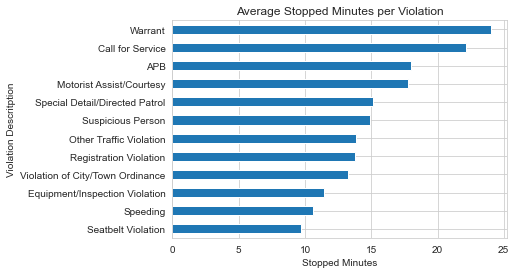

In [46]:
stop_length = ri.groupby(ri.violation_raw).stop_minutes.mean()
stop_length.sort_values().plot(kind = "barh")
plt.xlabel("Stopped Minutes")
plt.ylabel("Violation Descritption")
plt.title("Average Stopped Minutes per Violation")
plt.show()

I can also classify the stop durations into short, medium and long and assign them to a categorical data type. 

In [47]:
# Create a mapping dictionary to assign short, medium and long stops
cat_mapping = {8:"short", 23:"medium", 45:"long"}

# Map categories in a new column
ri["stop_length_cat"] = ri.stop_minutes.map(cat_mapping)

# Confirm mapping
ri.head()

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,inventory,stop_minutes,stop_length_cat
stop_date_time,,,,,,,,,,,,,,,,
2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short
2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8,short
2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short
2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False,23,medium
2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False,8,short


I can now convert the stop_length_cat column into categories. This will lower the memory usage but will also allow me to order the categories as I specify them.

In [48]:
# Create a CategoricaDtype pandas object, passing the values in the order I want and specifying that they are ordered.
cats = pd.CategoricalDtype(["short", "medium", "long"], ordered = True)

# Convert column to cat type
ri["stop_length_cat"] = ri.stop_length_cat.astype(cats)

# Validate
ri.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86536 entries, 2005-01-04 12:55:00 to 2015-12-31 22:47:00
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   stop_date           86536 non-null  object  
 1   stop_time           86536 non-null  object  
 2   driver_gender       86536 non-null  object  
 3   driver_race         86536 non-null  object  
 4   violation_raw       86536 non-null  object  
 5   violation           86536 non-null  object  
 6   search_conducted    86536 non-null  bool    
 7   search_type         3307 non-null   object  
 8   stop_outcome        86536 non-null  object  
 9   is_arrested         86536 non-null  bool    
 10  stop_duration       86536 non-null  object  
 11  drugs_related_stop  86536 non-null  bool    
 12  district            86536 non-null  object  
 13  inventory           86536 non-null  bool    
 14  stop_minutes        86536 non-null  int64   
 15  s

I can now perform calculations on the categories, for example, calculating the arrest rate per each stop duration category.

In [49]:
# Arrest rate per category
ri.groupby("stop_length_cat").is_arrested.mean()

stop_length_cat
short     0.013654
medium    0.093595
long      0.261572
Name: is_arrested, dtype: float64

Text(0.5, 1.0, 'Arrest Rate per Stop Duration Category')

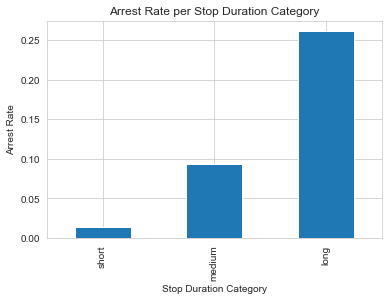

In [50]:
# Plot results
ri.groupby("stop_length_cat").is_arrested.mean().plot(kind = "bar")
plt.xlabel("Stop Duration Category")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate per Stop Duration Category")

### Analyzing relationship with weather data

Does weather affect police activity during traffic stops?

To find out, I´ll pull data out of NOAA for the single weather station in Rhode Island. 
The columns the dataset contain include: date, average temperature (TAVG), min and max temps (TMIN, TMAX), average wind speed (AWND) and the highest wind speed in the course of any 2 minutes (WSF2) and 22 columns reffering to certain bad weather conditions (ex. WT05 = Hail, WT11 = High or damaging winds, WT17 = Freezing Rain), where a 1 in WT columns indicate that bad weather presence or NaN meaning not present. 

In [51]:
weather = pd.read_csv("weather.txt")
print(weather.shape)
weather.head()

(4017, 27)


,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


It is good practice to explore the data to check that the data seems reasonable. 
I´ll take a look into the windspeed columns to check if the data makes sense: 

In [52]:
# Use describe to calculate summary statistics
weather[["AWND", "WSF2"]].describe()

,AWND,WSF2
count,4017.000000,4017.000000
mean,8.593707,19.274782
std,3.364601,5.623866
min,0.220000,4.900000
25%,6.260000,15.000000
50%,8.050000,17.900000
75%,10.290000,21.900000
max,26.840000,48.100000


The values seem reasonable since they are measured in MPH, and the minimum values are above zero and the fastest wind speed values are faster than the average wind speed values. I can also visualize the summary statistics with a boxplot, clearly identifying the min and max values, as well as the 25%, 50% and 75% percentiles.

<AxesSubplot:>

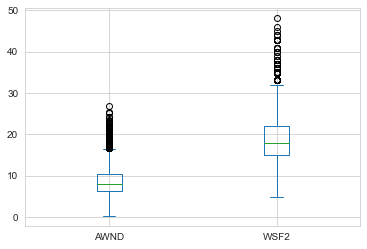

In [53]:
# Create a box plot
weather[["AWND", "WSF2"]].plot(kind = "box")

For sanity checks, I can also validate that the fastest wind speeds are greater than the average wind speed values for each row. To do so, I can investigate the difference between the columns for each row.

<AxesSubplot:ylabel='Frequency'>

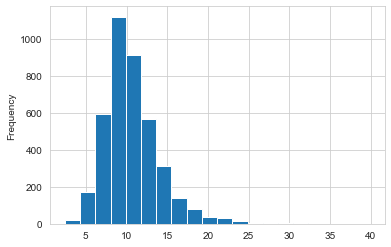

In [54]:
# Calculate difference between columns and store results in a new column "WDIFF"
weather["WDIFF"] = weather.WSF2 - weather.AWND

# Visualize the values distribution using a histogram
weather.WDIFF.plot(kind = "hist", bins = 20)

A good sign is that there are no values below zero and that the values are distributed in a normal bell shape curve. 
I will explore the temperature columns as well to confirm that the data is reliable for analysis. 

In [55]:
# Describe the temperature columns
weather[["TMIN", "TAVG", "TMAX"]].describe()

,TMIN,TAVG,TMAX
count,4017.000000,1217.000000,4017.000000
mean,43.484441,52.493016,61.268608
std,17.020298,17.830714,18.199517
min,-5.000000,6.000000,15.000000
25%,30.000000,39.000000,47.000000
50%,44.000000,54.000000,62.000000
75%,58.000000,68.000000,77.000000
max,77.000000,86.000000,102.000000


I can see that the values make sense as well since they are measured in Farenheit scale. I´ll plot the summary statistics to visualize the distribution of the data.

Text(0.5, 1.0, 'Temperature Statistics')

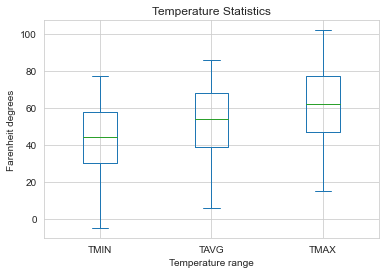

In [56]:
# Box plot summary statistics and assign labels
weather[["TMIN", "TAVG", "TMAX"]].plot(kind = "box")
plt.xlabel("Temperature range")
plt.ylabel("Farenheit degrees")
plt.title("Temperature Statistics")

As with the windspeed columns, I will validate the difference between the max and min temperatures for each observation.

In [57]:
# Create column to store the differece between the max and min temperatures
weather["TDIFF"] = weather.TMAX - weather.TMIN

# Describe TDIFF
weather[["TDIFF"]].describe()

,TDIFF
count,4017.000000
mean,17.784167
std,6.350720
min,2.000000
25%,14.000000
50%,18.000000
75%,22.000000
max,43.000000


<AxesSubplot:ylabel='Frequency'>

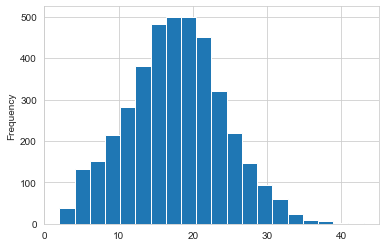

In [58]:
# PLot the distribution of the values for TDIFF
weather.TDIFF.plot(kind = "hist", bins = 20)

Now that the weather dataset is confirmed as a trustworthy source, I can prepare it for analysis.

I will begin by quantify how bad was the weather for each day by creating a new DF that contains only the WT columns and counting the number of 1s in each row. 

In [59]:
# Use .loc to slice the columns and copy them into a new DF [all rows, from:to columns]
WT = weather.loc[:,"WT01":"WT22"]
WT.shape

(4017, 20)

In [60]:
# Calculate the sum of each row in WT and assign the result in new column "bad_conditions" in weather dataset. 
# To sum all the columns value for each row, I set the axis = to columns parameter
weather["bad_conditions"] = WT.sum(axis = "columns")

#Replace missing values with 0 and set dtype to integer
weather["bad_conditions"] = weather.bad_conditions.fillna(0).astype("int")

# Inspect
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WDIFF,TDIFF,bad_conditions
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.15,18,2
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,4.70,16,2
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,10.07,9,3
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9.17,6,4
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,9.17,15,4


<AxesSubplot:ylabel='Frequency'>

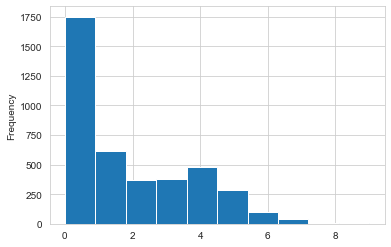

In [61]:
# Create a histogram to view bad conditions
weather.bad_conditions.plot(kind = "hist")

With the total bad weather conditions per day, I can now categorize each range of bad conditions:

- 0 as good
- 1 - 4 as bad
- 5 - 9 as worse

To do so, I will first count the unique values in bad_conditions and sort the index. Then I will create the mapping dictionary and map the values to their corresponding keys in a new column. At last, I will count the unique values again to verify the completion of the process.

In [62]:
# Count unique values and sort index
weather.bad_conditions.value_counts().sort_index()

0    1749
1     613
2     367
3     380
4     476
5     282
6     101
7      41
8       4
9       4
Name: bad_conditions, dtype: int64

In [63]:
# Create mapping dictionary
weather_mapping = {0:"good", 1:"bad", 2:"bad", 3:"bad", 4:"bad", 5:"worse", 6:"worse", 7:"worse", 8:"worse", 9:"worse"}

# Map values to keys in new column
weather["rating"] = weather.bad_conditions.map(weather_mapping)

# Count unique values again to verigy
print(weather.rating.value_counts())

# Inspect weather and new column
weather.head()

bad      1836
good     1749
worse     432
Name: rating, dtype: int64


,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT10,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22,WDIFF,TDIFF,bad_conditions,rating
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.15,18,2,bad
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,4.70,16,2,bad
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,10.07,9,3,bad
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9.17,6,4,bad
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,9.17,15,4,bad


I will now convert the rating column values into categories as previously done with the stop duration lengths.

In [64]:
#Create CategoricalDtype object with values ordered as desired
weather_cats = pd.CategoricalDtype(["good", "bad", "worse"], ordered = True)

# Convert rating column to categorical type
weather["rating"] = weather.rating.astype(weather_cats)

# Inspect data types
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   STATION         4017 non-null   object  
 1   DATE            4017 non-null   object  
 2   TAVG            1217 non-null   float64 
 3   TMIN            4017 non-null   int64   
 4   TMAX            4017 non-null   int64   
 5   AWND            4017 non-null   float64 
 6   WSF2            4017 non-null   float64 
 7   WT01            1767 non-null   float64 
 8   WT02            221 non-null    float64 
 9   WT03            224 non-null    float64 
 10  WT04            117 non-null    float64 
 11  WT05            360 non-null    float64 
 12  WT06            25 non-null     float64 
 13  WT07            79 non-null     float64 
 14  WT08            404 non-null    float64 
 15  WT09            69 non-null     float64 
 16  WT10            2 non-null      float64 
 17  WT11          

I am now ready to merge the weather data with the ri police stops data. For this, I will create a new dataframe of the weather DF that only contains the date and the weather rating columns. Then, I will reset the index of the ri DF so that date_time column can be part of the columns as well. Lastly, I will left-join the new DF onto the ri dataframe using the date and DATE columns in order to keep all rows for the ri DF even though they dont have a matching weather rating column and re set the index to the stop_date_time column.

In [65]:
# Create new DataFrame with only the Date and rating
weather_rating = weather[["DATE", "rating"]]

# Inspect it
weather_rating.head()

,DATE,rating
0,2005-01-01,bad
1,2005-01-02,bad
2,2005-01-03,bad
3,2005-01-04,bad
4,2005-01-05,bad


In [66]:
# Reset the ri index
ri.reset_index(inplace = True)

# Inspect ri
ri.head()

,stop_date_time,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,inventory,stop_minutes,stop_length_cat
0,2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short
1,2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8,short
2,2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short
3,2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False,23,medium
4,2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False,8,short


In [67]:
# Left-join both data-sets, left on "stop_date", right on "Date" and create a new merged DF
ri_weather = pd.merge(left = ri, right = weather_rating, left_on = "stop_date", right_on = "DATE", how = "left")

# Set index to stop_date_time
ri_weather.set_index("stop_date_time", inplace = True)

# Inspect merged DF
ri_weather.head()

,stop_date,stop_time,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district,inventory,stop_minutes,stop_length_cat,DATE,rating
stop_date_time,,,,,,,,,,,,,,,,,,
2005-01-04 12:55:00,2005-01-04,12:55,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short,2005-01-04,bad
2005-01-23 23:15:00,2005-01-23,23:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3,False,8,short,2005-01-23,worse
2005-02-17 04:15:00,2005-02-17,04:15,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4,False,8,short,2005-02-17,good
2005-02-20 17:15:00,2005-02-20,17:15,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1,False,23,medium,2005-02-20,bad
2005-02-24 01:20:00,2005-02-24,01:20,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3,False,8,short,2005-02-24,bad


Now I can investigate the relationship between the weather rating and the traffic stop behaviours.

In [68]:
# Investigate the arrest rate for each violation given any weather rating
arrest_weather_rate = ri_weather.groupby(["violation","rating"]).is_arrested.mean()

# View allviolations and weather ratings arrest rate
print(arrest_weather_rate)

violation            rating
Equipment            good      0.059007
                     bad       0.066311
                     worse     0.097357
Moving violation     good      0.056227
                     bad       0.058050
                     worse     0.065860
Other                good      0.076966
                     bad       0.087443
                     worse     0.062893
Registration/plates  good      0.081574
                     bad       0.098160
                     worse     0.115625
Seat belt            good      0.028587
                     bad       0.022493
                     worse     0.000000
Speeding             good      0.013405
                     bad       0.013314
                     worse     0.016886
Name: is_arrested, dtype: float64


The groupby result is stored in a MultiIndex object. It behaves similar to a DF, being the first index (violation) as columns and the second index (rating) as rows. I can use .loc to access specific values.

In [69]:
# Speeding violation for all weather ratings
arrest_weather_rate.loc["Speeding"]

rating
good     0.013405
bad      0.013314
worse    0.016886
Name: is_arrested, dtype: float64

In [70]:
# Equipment violation for bad weather only
arrest_weather_rate.loc["Equipment", "bad"]

0.06631142687981054

To convert a MultiIndex into a DataFrame, I can use pandas method .unstack():

In [71]:
# Unstack
arrest_weather_rate_df = arrest_weather_rate.unstack()

# Review DF
arrest_weather_rate_df.head()

rating,good,bad,worse
violation,,,
Equipment,0.059007,0.066311,0.097357
Moving violation,0.056227,0.058050,0.065860
Other,0.076966,0.087443,0.062893
Registration/plates,0.081574,0.098160,0.115625
Seat belt,0.028587,0.022493,0.000000


I can get the same result by using a pivot table by settind the index parameter to "violation", the columns parameter to "rating", and the values to "is_arrested". The default function for the values of the pivot table is the mean, but I can pass other functions as well. 

In [72]:
# Create pivot table
ri_weather.pivot_table(index = "violation", columns = "rating", values = "is_arrested")

rating,good,bad,worse
violation,,,
Equipment,0.059007,0.066311,0.097357
Moving violation,0.056227,0.058050,0.065860
Other,0.076966,0.087443,0.062893
Registration/plates,0.081574,0.098160,0.115625
Seat belt,0.028587,0.022493,0.000000
Speeding,0.013405,0.013314,0.016886


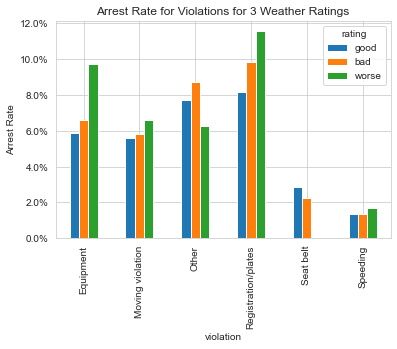

In [73]:
# Visualize results and 
arrest_plot = arrest_weather_rate_df.plot(kind = "bar")
arrest_plot.yaxis.set_major_formatter(PercentFormatter(1.0))
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate for Violations for 3 Weather Ratings")
plt.show()

The data that arrest rates are lower for all violations excluding seat belt violations. It also shows that arrest rates go up as the weather gets worse! This is a clear correlation on how weather and arrest rates relate to each other (not that one causes the other, they are only related).

A 0% arrest rate for seat belt violations can mean that drivers are not arrested for not wearing their seatbelt during the worst weather conditions.

### Project conclusions

This was a fun project, where whole analysis process was performed, from preparing to analyzing the data. We cleaned messy data, created visualizations and answered questions along the way. We found correlations between variables and tested different hypothesis about the data. 

This project shows the correlations between different varaiables and their effects on other variables, however, they do not state causation - only correlation. 

Thank you for reading and followng me along this project. Feedback is very welcomed!